# Testing Notebook

## Some Theory about Recommender Systems

The main families of methods for RecSys are:

- Collaborative Filtering: This method makes automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on a set of items, A is more likely to have B's opinion for a given item than that of a randomly chosen person.

- Content-Based Filtering: This method uses only information about the description and attributes of the items users has previously consumed to model user's preferences. In other words, these algorithms try to recommend items that are similar to those that a user liked in the past (or is examining in the present). In particular, various candidate items are compared with items previously rated by the user and the best-matching items are recommended.

- Hybrid methods: Recent research has demonstrated that a hybrid approach, combining collaborative filtering and content-based filtering could be more effective than pure approaches in some cases. These methods can also be used to overcome some of the common problems in recommender systems such as cold start and the sparsity problem.

https://www.kaggle.com/code/gspmoreira/recommender-systems-in-python-101

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

In [2]:
import scipy
import math
import random
import sklearn
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler

## 1. ItemBased Collaborative Filter Recommendation

Example: https://www.kaggle.com/code/hendraherviawan/itembased-collaborative-filter-recommendation-r/report

(Mileva) The following cell, ie, loading from the parquet removes the issue you were seeing with the customer_id being of different types. Hypothetically, we can replace all of 2.1 with the code block below. Note: we have to move the imputation of null values to the 01_processing notebook (before creating the parquet) is all. 

In [2]:
#(Mileva added)
# transactions = pd.read_parquet('data/transactions_train_sample_gt15transactions.parquet')
# customers = pd.read_parquet('data/customers_sample_gt15transactions.parquet')
# articles = pd.read_parquet('data/articles_sample_gt15transactions.parquet')

### 2.1 Preprocessing

In [3]:
articles = pd.read_csv("data/articles.csv")
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [4]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

In [5]:
#article_id is a int. Convert to string.
articles['article_id'] = articles['article_id'].astype(str) 

In [6]:
#keep only the columns of interest
articles = articles[['article_id', 'product_type_name', 'graphical_appearance_name', 'perceived_colour_master_name', 'section_name']]

In [7]:
articles.head()

,article_id,product_type_name,graphical_appearance_name,perceived_colour_master_name,section_name
0,108775015,Vest top,Solid,Black,Womens Everyday Basics
1,108775044,Vest top,Solid,White,Womens Everyday Basics
2,108775051,Vest top,Stripe,White,Womens Everyday Basics
3,110065001,Bra,Solid,Black,Womens Lingerie
4,110065002,Bra,Solid,White,Womens Lingerie


In [8]:
customers = pd.read_csv("data/customers.csv")
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [9]:
#keep only the columns of interest
customers = customers[['customer_id', 'fashion_news_frequency', 'age']]

In [10]:
customers.head()

,customer_id,fashion_news_frequency,age
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NONE,49.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NONE,25.0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NONE,24.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NONE,54.0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,Regularly,52.0


In [11]:
transactions = pd.read_csv("data/transactions_train.csv")
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001.0,0.050831,2.0
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023.0,0.030492,2.0
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004.0,0.015237,2.0
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003.0,0.016932,2.0
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004.0,0.016932,2.0


In [12]:
#keep only the columns of interest
transactions = transactions[['customer_id', 'article_id', 'price']]
transactions.head()

,customer_id,article_id,price
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001.0,0.050831
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023.0,0.030492
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004.0,0.015237
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003.0,0.016932
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004.0,0.016932


In [13]:
#article_id is a float. First convert to int and then to string.
transactions['article_id'] = transactions['article_id'].astype("Int64").astype(str) 

### 2.2 Build single dataframe: Articles + Transactions + Customers

#### Create Transactions subset for testing

In [14]:
#transactions_subset = transactions.sample(100000, random_state=0)
transactions_subset = transactions

In [15]:
transactions_subset.head()

,customer_id,article_id,price
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932


In [16]:
transactions_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16043763 entries, 0 to 16043762
Data columns (total 3 columns):
 #   Column       Dtype  
---  ------       -----  
 0   customer_id  object 
 1   article_id   object 
 2   price        float64
dtypes: float64(1), object(2)
memory usage: 367.2+ MB


#### Join Transactions and Articles dataframes

In [17]:
#transactions_articles_joined = transactions_subset.set_index('article_id').join(articles.set_index('article_id'))
transactions_articles_joined = transactions_subset.join(articles.set_index('article_id'), on='article_id')

In [18]:
transactions_articles_joined.head()

,customer_id,article_id,price,product_type_name,graphical_appearance_name,perceived_colour_master_name,section_name
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,Underwear body,Solid,Black,Womens Lingerie
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,Bra,Solid,Pink,Womens Lingerie
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,Sweater,Melange,Pink,Divided Selected
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,Sweater,Melange,Pink,Womens Everyday Collection
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,Sweater,Melange,Green,Womens Everyday Collection


#### Join Transactions-Articles with Customers dataframes

In [19]:
# Join also customer info

#trans_arts_cust_joined = transactions_articles_joined.set_index('customer_id').join(customers.set_index('customer_id'))
features_joined = transactions_articles_joined.join(customers.set_index('customer_id'), on='customer_id')
features_joined.head()

#Index of output df belongs to original index of transactions

,customer_id,article_id,price,product_type_name,graphical_appearance_name,perceived_colour_master_name,section_name,fashion_news_frequency,age
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,Underwear body,Solid,Black,Womens Lingerie,NONE,24.0
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,Bra,Solid,Pink,Womens Lingerie,NONE,24.0
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,Sweater,Melange,Pink,Divided Selected,Regularly,32.0
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,Sweater,Melange,Pink,Womens Everyday Collection,Regularly,32.0
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,Sweater,Melange,Green,Womens Everyday Collection,Regularly,32.0


#### Check if join has been done correctly

In [20]:
#1. check that customer_id are repeated (some customers bought multiple items)
#Number of products purchased by each customer
grouped = features_joined.groupby("customer_id")["customer_id"].count().reset_index(name='counts').sort_values(by='counts', ascending=False)
grouped

,customer_id,counts
683982,b14bfba3ae0da5af6e9711059773acf713cd7bb9a2c940...,897
733432,be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee9...,819
511891,84c34f4f564db1f437943c77af41f83bf6fd7c01701cbb...,731
802295,d00063b94dcb1342869d4994844a2742b5d62927f36843...,730
46064,0bf4c6fd4e9d33f9bfb807bb78348cbf5c565846ff4006...,674
...,...,...
312298,5126e4062c035c53ac1b2a2dedf2fd09724d4f52677f90...,1
769715,c78c4b04098ca1438dd4570ab3a53651616605a283b2e6...,1
769719,c78c73c45b31be4e6a38c9e1db467a96954650004b3fcd...,1
312295,5126db4d0bf54a5b59176545b3dde26407af1d7576c04f...,1


In [21]:
#2. check that article_id are repeated (different customers bought same item)
#Number of times the products were purchased by the customers
grouped = features_joined.groupby("article_id")["article_id"].count().reset_index(name='counts').sort_values(by='counts', ascending=False)
grouped

,article_id,counts
49710,706016001,17726
49711,706016002,16489
1502,372860001,15388
13026,562245001,14793
22952,610776002,14628
...,...,...
3682,478004012,1
12706,560375002,1
12705,560375001,1
64837,773223001,1


In [22]:
#3. Check duplicated rows
features_joined.duplicated().sum()

1873067

Duplicate rows correspond to multiple purchases of the same item by the same client. 

In [23]:
features_joined.head()

,customer_id,article_id,price,product_type_name,graphical_appearance_name,perceived_colour_master_name,section_name,fashion_news_frequency,age
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,Underwear body,Solid,Black,Womens Lingerie,NONE,24.0
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,Bra,Solid,Pink,Womens Lingerie,NONE,24.0
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,Sweater,Melange,Pink,Divided Selected,Regularly,32.0
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,Sweater,Melange,Pink,Womens Everyday Collection,Regularly,32.0
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,Sweater,Melange,Green,Womens Everyday Collection,Regularly,32.0


### 2.4 Manage Null values

In [24]:
features_joined.isnull().sum()

customer_id                         0
article_id                          0
price                               1
product_type_name                   1
graphical_appearance_name           1
perceived_colour_master_name        1
section_name                        1
fashion_news_frequency          64810
age                             79980
dtype: int64

In [25]:
#Replace Age with the mean
mean_age = features_joined['age'].median()
features_joined['age'].fillna(mean_age,inplace=True)

In [26]:
#Replace fashion_news_frequency with the most common value
features_joined = features_joined.fillna(features_joined['fashion_news_frequency'].value_counts().index[0])

In [27]:
features_joined.isnull().sum()

customer_id                     0
article_id                      0
price                           0
product_type_name               0
graphical_appearance_name       0
perceived_colour_master_name    0
section_name                    0
fashion_news_frequency          0
age                             0
dtype: int64

### 2.4 Manage Categorical Columns

#### Explore levels of the categorical variables

In [28]:
features_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16043763 entries, 0 to 16043762
Data columns (total 9 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   customer_id                   object 
 1   article_id                    object 
 2   price                         object 
 3   product_type_name             object 
 4   graphical_appearance_name     object 
 5   perceived_colour_master_name  object 
 6   section_name                  object 
 7   fashion_news_frequency        object 
 8   age                           float64
dtypes: float64(1), object(8)
memory usage: 1.1+ GB


#### Handle categorical variables

In [29]:
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder

# # apply 1-hot encoding to catgorical predictors
# pip = ColumnTransformer([
#         ("cat", OneHotEncoder(), ["article_id", "sales_channel_id", "product_code", "product_type_no", "graphical_appearance_no", "colour_group_code", 
#                                   "perceived_colour_value_id", "perceived_colour_master_id", "index_code", "index_group_no", "section_no",
#                                   "garment_group_no", "club_member_status", "fashion_news_frequency"]),
#     ], remainder='drop')

In [30]:
# features_prepared = pd.DataFrame(pip.fit_transform(features_joined))
# features_prepared

In [151]:
features_prepared = features_joined

### 2.5 Machine Learning

https://www.datasource.ai/uploads/6b86b1630562b323a26143f90d97fe08.html

#### 2.5.1 Collaborative filtering

Build a matrix of items for the client

##### 2.5.1.1 Subset Data

We have a lot of data so lets make an initial random subset

In [152]:
features_prepared_sample1 = features_prepared.sample(3000000, random_state=0)
#features_prepared_sample1 = features_prepared.sample(600000, random_state=0) #This one is only for testing purposes

Now we can subset the sample data by removing costumers with a low number of purchases. Collaborative and item based filter performs better when the history data is big.

How many customers would be remaining if we remove all of those wo has less than 10 purchases? 

In [153]:
#Number of products purchased by each customer
customers_counts = features_prepared_sample1.groupby("customer_id")["customer_id"].count().reset_index(name='counts')
#Number of people that purchased 1,2...n items
grouped = customers_counts.groupby("counts")["counts"].count()
grouped

counts
1      223562
2      133928
3       86317
4       59859
5       43686
        ...  
128         1
135         1
140         1
156         1
198         1
Name: counts, Length: 114, dtype: int64

In [154]:
customers_counts

,customer_id,counts
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,1
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,9
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,1
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1
4,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,1
...,...,...
708444,ffff64f7850d4268016db8db3d48bf5433db2a926ba71b...,6
708445,ffff8f9ecdce722b5bab97fff68a6d1866492209bfe524...,2
708446,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,4
708447,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,5


We can subset the dataset based on the clients that have more than 15 purchases, since we would still have enough data.

In [155]:
remove_custs = customers_counts[customers_counts["counts"] <= 15]["customer_id"].tolist() #Customers with 1 or 2 purchases
remove_custs[0:10]

['00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657',
 '0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa',
 '000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318',
 '00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a',
 '0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d8cd0c725276a467a2a',
 '000097d91384a0c14893c09ed047a963c4fc6a5c021044eec603b323e8c82d1d',
 '00009c2aeae8761f738e4f937d9be6b49861a66339c2b1c3b1cc6e322729a370',
 '00009d946eec3ea54add5ba56d5210ea898def4b46c68570cf0096d962cacc75',
 '0000b2f1829e23b24feec422ef13df3ccedaedc85368e6664d04ca30b2f8daff',
 '0000c97821eb48d0e590fd309133f0a6c08f7750f64cccf2ba053e11119093c2']

Subset data by removing clients with only one and two purchases

In [36]:
features_prepared_sample = features_prepared_sample1[~features_prepared_sample1['customer_id'].isin(remove_custs)]

In [37]:
len(features_prepared_sample)

610737

Lets work with this sample of 600000 elements.

In [38]:
#df = features_prepared.reset_index()
#features_prepared_sample = features_prepared[0:200000].reset_index()

In [168]:
features_prepared_sample.head()

,customer_id,article_id,price,product_type_name,graphical_appearance_name,perceived_colour_master_name,section_name,fashion_news_frequency,age,Quantity
7347469,1caf62af1fca9d95f42315b7f7866d4b1e10dc9068035b...,504154020,0.022017,Sweater,Melange,Grey,Womens Everyday Collection,NONE,27.0,1
15356593,9e5f9779bdc2cd9a5aad66222034ae6b25d2cb6fbaa568...,758611002,0.053373,Skirt,All over pattern,Yellow,Womens Everyday Collection,Regularly,40.0,1
4621974,532a4be8bb46d8e3d6cfb2271b7151d390fccb8b0e5a2f...,599719008,0.020322,Skirt,All over pattern,Unknown,Womens Casual,NONE,46.0,1
2979109,6d764eacad5ebe234ce6c97fb5f802d2e70b62d8f13b46...,507987024,0.013542,Scarf,Solid,Pink,Divided Accessories,NONE,25.0,1
29292,9931188ca26014c7b81e5aa9a597289504a5f2237a3f51...,548467001,0.016932,Sweater,Solid,Black,Divided Collection,Regularly,25.0,1


In [40]:
#Get counts of each sold article
grouped = features_prepared_sample.groupby("article_id")["article_id"].count().reset_index(name='counts').sort_values(by=['counts'], ascending=False)
grouped

,article_id,counts
1263,678342001,22
382,561445005,5
2046,734287001,4
117,443262012,4
1200,673638001,4
...,...,...
925,647434001,1
926,647751002,1
927,647804001,1
928,647841001,1


In [41]:
#Get counts of each customer to see if same customer has purchased more than once
grouped = features_prepared_sample.groupby("customer_id")["customer_id"].count().reset_index(name='counts').sort_values(by=['counts'], ascending=False)
grouped

,customer_id,counts
109,b14bfba3ae0da5af6e9711059773acf713cd7bb9a2c940...,35
78,84c34f4f564db1f437943c77af41f83bf6fd7c01701cbb...,33
61,689f4eda82fdf3d9bfe8e524bbd0d931c4d7690f2234d3...,33
26,30d1e9b6378a74a740f64c3d34f1686693d0430b03c6cd...,31
143,efaafb08a00e63ce561a67c31c1ab7e720d4f394a78c47...,28
...,...,...
58,6699f75dc4bb992d6053c202fcf4141e1940011871b917...,16
15,19cc4d7709d118346e0f3230584bf3c800d34831550229...,16
54,63030e3780172f975ffb2418aa613f40ec45bdcd6033d2...,16
47,582fed0b2eb44b7b5821104b25d9f36898129774209deb...,16


##### 2.5.1.2 Build customer-articles matrix

In [ ]:
#Add column quantity
features_prepared_sample['Quantity'] = 1

In [170]:
features_prepared_sample.head()

,customer_id,article_id,price,product_type_name,graphical_appearance_name,perceived_colour_master_name,section_name,fashion_news_frequency,age,Quantity
7347469,1caf62af1fca9d95f42315b7f7866d4b1e10dc9068035b...,504154020,0.022017,Sweater,Melange,Grey,Womens Everyday Collection,NONE,27.0,1
15356593,9e5f9779bdc2cd9a5aad66222034ae6b25d2cb6fbaa568...,758611002,0.053373,Skirt,All over pattern,Yellow,Womens Everyday Collection,Regularly,40.0,1
4621974,532a4be8bb46d8e3d6cfb2271b7151d390fccb8b0e5a2f...,599719008,0.020322,Skirt,All over pattern,Unknown,Womens Casual,NONE,46.0,1
2979109,6d764eacad5ebe234ce6c97fb5f802d2e70b62d8f13b46...,507987024,0.013542,Scarf,Solid,Pink,Divided Accessories,NONE,25.0,1
29292,9931188ca26014c7b81e5aa9a597289504a5f2237a3f51...,548467001,0.016932,Sweater,Solid,Black,Divided Collection,Regularly,25.0,1


In [171]:
len(features_prepared_sample)

610737

In [172]:
customer_item_matrix = features_prepared_sample.pivot_table(
    index='customer_id', 
    columns='article_id', 
    values='Quantity',
    aggfunc='sum'
)

In [175]:
customer_item_matrix

article_id,108775015,108775044,108775051,110065001,110065002,110065011,111565001,111565003,111586001,111593001,...,829135001,829783001,829783005,829783006,829846002,830755001,831446001,832616001,834031001,834292001
customer_id,,,,,,,,,,,,,,,,,,,,,
00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37e011580a479e80aa94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000608ab13228c9d4f90f2e7e7dfd3b0c280d84ae817bfc899a0d3e7e01932f0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0008d30a148478dc88c69af6c51230ad5802590afc84889af16b661e64407408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000a74a8ce6e616c1d26d186d8ffae487878b89223b60f5d369665e367faa677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff7e7674509592818bf453391af43a85eaaac9a52d8587c886a603aeeb7df64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fff94dc337611d634cb102e99254b4bb3297ef0797cf681cd7bd1040470d734f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fff969b13a1c848d53ae3f08f111bfebcdcf6cd27e3815235db95f1e99524c79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 we now have a matrix where each row represents the total quantities purchased for each product for each customer.

let's code 0-1 this data, so that a value of 1 means that the given product was bought by the given customer, and a value of 0 means that the given product was never bought by the given customer. Take a look at the following code:

In [176]:
customer_item_matrix = customer_item_matrix.applymap(lambda x: 1 if x > 0 else 0)

In [177]:
customer_item_matrix

article_id,108775015,108775044,108775051,110065001,110065002,110065011,111565001,111565003,111586001,111593001,...,829135001,829783001,829783005,829783006,829846002,830755001,831446001,832616001,834031001,834292001
customer_id,,,,,,,,,,,,,,,,,,,,,
00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37e011580a479e80aa94,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000608ab13228c9d4f90f2e7e7dfd3b0c280d84ae817bfc899a0d3e7e01932f0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0008d30a148478dc88c69af6c51230ad5802590afc84889af16b661e64407408,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000a74a8ce6e616c1d26d186d8ffae487878b89223b60f5d369665e367faa677,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff7e7674509592818bf453391af43a85eaaac9a52d8587c886a603aeeb7df64,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fff94dc337611d634cb102e99254b4bb3297ef0797cf681cd7bd1040470d734f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fff969b13a1c848d53ae3f08f111bfebcdcf6cd27e3815235db95f1e99524c79,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### 2.5.1.3 Build Customers Similarity Matrix

Calculate the cosine similarities between users

In [51]:
from sklearn.metrics.pairwise import cosine_similarity

In [179]:
user_user_sim_matrix = pd.DataFrame(
    cosine_similarity(customer_item_matrix)
)

In [180]:
user_user_sim_matrix

,0,1,2,3,4,5,6,7,8,9,...,25801,25802,25803,25804,25805,25806,25807,25808,25809,25810
0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.047836,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.038749,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25806,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0
25807,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0
25808,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0
25809,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.042563,0.0,0.0,0.0,1.0,0.0


In [181]:
user_user_sim_matrix.columns = customer_item_matrix.index

In [182]:
user_user_sim_matrix

customer_id,00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37e011580a479e80aa94,000608ab13228c9d4f90f2e7e7dfd3b0c280d84ae817bfc899a0d3e7e01932f0,0008d30a148478dc88c69af6c51230ad5802590afc84889af16b661e64407408,000a74a8ce6e616c1d26d186d8ffae487878b89223b60f5d369665e367faa677,000fb6e772c5d0023892065e659963da90b1866035558ec16fca51b0dcfb7e59,0015251a0dcebac75714f68f50a9a282731dc2c8269f7a20cfa81e144fb27551,0016b98191cdd059be5662dbf1d2b634cbfb7132b1d62f1c0d2e55bd95fef6e7,0018a4640de2338492de0fcc8325d6f6687d0c7980d804d8d8e4c5bfd24456d7,001b219dc92b964f2bc708fcdc8248e4911b7459aa1fd3a5f20eb3201b477e29,...,ffe4bd3f42225fb51da4fe110a0fb2519efef670ff07eeb1af2da794f54ca88b,ffe6376eb6b854d842e5a7714ea758de127f086a60d67d5cf425ef20361acea1,ffed71450acc902268fc4b99dfdc28f1a22583f573863b8639fe26671be9db40,fff2021a309a979417359152629d2cde8c538c3a902fa3e3034b7bb38166f835,fff3573d9131d15da6a46c1ca8f03b5d37e4f6b804171ea27278a18a2d8ca0c7,fff7e7674509592818bf453391af43a85eaaac9a52d8587c886a603aeeb7df64,fff94dc337611d634cb102e99254b4bb3297ef0797cf681cd7bd1040470d734f,fff969b13a1c848d53ae3f08f111bfebcdcf6cd27e3815235db95f1e99524c79,fffabaebcc10efa0e613b58de37901e04fa25a2f90a0a8cba67e3b9a57497ab5,fffe7116f9f68e8ad287fd7b6e33aad4871d7080e77d2d5e52636ba1c27cf032
0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.047836,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.038749,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25806,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0
25807,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0
25808,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0
25809,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.042563,0.0,0.0,0.0,1.0,0.0


In [183]:
user_user_sim_matrix['customer_id'] = customer_item_matrix.index
user_user_sim_matrix = user_user_sim_matrix.set_index('customer_id')

In [184]:
user_user_sim_matrix

customer_id,00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37e011580a479e80aa94,000608ab13228c9d4f90f2e7e7dfd3b0c280d84ae817bfc899a0d3e7e01932f0,0008d30a148478dc88c69af6c51230ad5802590afc84889af16b661e64407408,000a74a8ce6e616c1d26d186d8ffae487878b89223b60f5d369665e367faa677,000fb6e772c5d0023892065e659963da90b1866035558ec16fca51b0dcfb7e59,0015251a0dcebac75714f68f50a9a282731dc2c8269f7a20cfa81e144fb27551,0016b98191cdd059be5662dbf1d2b634cbfb7132b1d62f1c0d2e55bd95fef6e7,0018a4640de2338492de0fcc8325d6f6687d0c7980d804d8d8e4c5bfd24456d7,001b219dc92b964f2bc708fcdc8248e4911b7459aa1fd3a5f20eb3201b477e29,...,ffe4bd3f42225fb51da4fe110a0fb2519efef670ff07eeb1af2da794f54ca88b,ffe6376eb6b854d842e5a7714ea758de127f086a60d67d5cf425ef20361acea1,ffed71450acc902268fc4b99dfdc28f1a22583f573863b8639fe26671be9db40,fff2021a309a979417359152629d2cde8c538c3a902fa3e3034b7bb38166f835,fff3573d9131d15da6a46c1ca8f03b5d37e4f6b804171ea27278a18a2d8ca0c7,fff7e7674509592818bf453391af43a85eaaac9a52d8587c886a603aeeb7df64,fff94dc337611d634cb102e99254b4bb3297ef0797cf681cd7bd1040470d734f,fff969b13a1c848d53ae3f08f111bfebcdcf6cd27e3815235db95f1e99524c79,fffabaebcc10efa0e613b58de37901e04fa25a2f90a0a8cba67e3b9a57497ab5,fffe7116f9f68e8ad287fd7b6e33aad4871d7080e77d2d5e52636ba1c27cf032
customer_id,,,,,,,,,,,,,,,,,,,,,
00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.047836,0.0,0.0,0.0,0.0,0.0
0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37e011580a479e80aa94,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
000608ab13228c9d4f90f2e7e7dfd3b0c280d84ae817bfc899a0d3e7e01932f0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
0008d30a148478dc88c69af6c51230ad5802590afc84889af16b661e64407408,0.0,0.0,0.0,1.0,0.0,0.038749,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
000a74a8ce6e616c1d26d186d8ffae487878b89223b60f5d369665e367faa677,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff7e7674509592818bf453391af43a85eaaac9a52d8587c886a603aeeb7df64,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0
fff94dc337611d634cb102e99254b4bb3297ef0797cf681cd7bd1040470d734f,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0
fff969b13a1c848d53ae3f08f111bfebcdcf6cd27e3815235db95f1e99524c79,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0


##### SKIP 2.5.1.3 Test on one user: Get recommended items for User A according to the items purchased by a similar User B

In [ ]:
#Find similar users as customer with id b14bfba3ae0da5af6e9711059773acf713cd7bb9a2c940ddf570affb715988a0
user_user_sim_matrix.loc['b14bfba3ae0da5af6e9711059773acf713cd7bb9a2c940ddf570affb715988a0'].sort_values(ascending=False)[0:10]

These are the 10 most similar clients to the b14bfba3ae0da5af6e9711059773acf713cd7bb9a2c940ddf570affb715988a0 client. Let's choose client 26f41c2913090e7a620df05975a52c604caf017c3110bb62596fdebd1aae4ba9 and discuss how we can recommend products using these results.

Lets identify both users:
- user_A: b14bfba3ae0da5af6e9711059773acf713cd7bb9a2c940ddf570affb715988a0
- user_B: 26f41c2913090e7a620df05975a52c604caf017c3110bb62596fdebd1aae4ba9

The strategy is as follows.

- First, we need to identify the items that user_A and user2 customers have already purchased.
- Then, let's find the products that target client user_B has not purchased, but client user_A has.
- Since these two customers have bought similar items in the past, we will assume that target customer user_B has a high probability of buying the items he or she has not bought, but customer user_A has.
- Finally, we are going to use this list of items and recommend them to target customer user_B.

Let's first see how we can retrieve the items that the user_A customer has purchased in the past:

In [59]:
user_A = "b14bfba3ae0da5af6e9711059773acf713cd7bb9a2c940ddf570affb715988a0"
user_B = "303b79786850ccfd146becd8bed5f33e0d770cab100090228a2b35b0f4b07c78"

In [60]:
items_bought_by_A = set(customer_item_matrix.loc[user_A].iloc[
    customer_item_matrix.loc[user_A].to_numpy().nonzero()
].index)

In [ ]:
items_bought_by_A

Using this function in the customer_item_matrix for the given user_A client, we can get the list of elements that the user_A client has purchased. We can apply the same code for the target client user_B, as in the following:

In [62]:
items_bought_by_B = set(customer_item_matrix.loc[user_B].iloc[
    customer_item_matrix.loc[user_B].to_numpy().nonzero()
].index)

In [ ]:
items_bought_by_B

We now have two sets of items that customers A and B have purchased. Using a simple set operation, we can find the items that customer A has purchased, but customer B has not. The code is like the one below:

In [64]:
items_to_recommend_to_A = items_bought_by_B - items_bought_by_A

In [ ]:
items_to_recommend_to_A

To obtain the descriptions of these items:

@to-do: We cannot drop article name from original articles dataframe. We have to drop columns after the join so that we still have articles dataframe to map the articles with the names. We shoukd have a mapping id-name after encoding

In [ ]:
# articles.loc[
#     articles['article_id'].isin(items_to_recommend_to_B), 
#     ['article_id', 'prod_name', 'product_type_name']
# ].drop_duplicates().set_index('article_id')

In [67]:
column_names = ["costumer_id", "recom_articles"]
costumers_rec_articles_df = pd.DataFrame(columns = column_names)

In [ ]:
costumers_rec_articles_df = costumers_rec_articles_df.append({'costumer_id': user_A, 'recom_articles':items_to_recommend_to_A}, ignore_index=True)
costumers_rec_articles_df

##### 2.5.1.2 Build the recommendations for each customer

In [185]:
# Create empty dataframe that will store the customers and their recommended products
column_names = ["costumer_id", "recom_articles"]
costumers_rec_articles_df = pd.DataFrame(columns = column_names)

In [186]:
%%capture --no-display 

for i in range(len(customer_item_matrix)-1):   
    customer_i_id = customer_item_matrix.index[i]
    items_to_recommend_to_i = set()

    items_bought_by_i = set(customer_item_matrix.loc[customer_i_id].iloc[customer_item_matrix.loc[customer_i_id].to_numpy().nonzero()].index)
    
    #Get most similar users to current user i
    similar_users = user_user_sim_matrix.iloc[i].sort_values(ascending=False)[0:10] #get just the 10 most similar clients
    similar_users = similar_users[similar_users!=0].to_frame() #Get only clients with similarity score greater than 0

    #Get articles bought by the j similar users
    for j in similar_users.index.values:
        customer_j_id = j
        items_bought_by_j = set(customer_item_matrix.loc[customer_j_id].iloc[customer_item_matrix.loc[customer_j_id].to_numpy().nonzero()].index)
        items_to_recommend = items_bought_by_j - items_bought_by_i
        #if(len(items_to_recommend)>0): items_to_recommend_to_i.append(items_to_recommend)
        items_to_recommend_to_i = set.union(items_to_recommend_to_i, items_to_recommend)

    costumers_rec_articles_df = costumers_rec_articles_df.append({'costumer_id': customer_i_id, 'recom_articles':items_to_recommend_to_i}, ignore_index=True)


In [227]:
costumers_rec_articles_df

,costumer_id,recom_articles
0,00007d2de826758b65a93dd24ce629ed66842531df6699...,"{450662010, 708536002, 699342003, 523490004, 6..."
1,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,"{547367022, 660726002, 768759004, 762630001, 6..."
2,000608ab13228c9d4f90f2e7e7dfd3b0c280d84ae817bf...,"{607154001, 689562001, 702118003, 803276001, 5..."
3,0008d30a148478dc88c69af6c51230ad5802590afc8488...,"{554772002, 610744009, 671949002, 554598057, 6..."
4,000a74a8ce6e616c1d26d186d8ffae487878b89223b60f...,"{792376001, 771537001, 757748003, 700737003, 7..."
...,...,...
25805,fff3573d9131d15da6a46c1ca8f03b5d37e4f6b804171e...,"{772537001, 712924008, 696780006, 399201002, 2..."
25806,fff7e7674509592818bf453391af43a85eaaac9a52d858...,"{622598001, 773781002, 722475005, 605571011, 6..."
25807,fff94dc337611d634cb102e99254b4bb3297ef0797cf68...,"{512251012, 590489005, 554811008, 498738018, 7..."
25808,fff969b13a1c848d53ae3f08f111bfebcdcf6cd27e3815...,"{700817001, 685347011, 767869002, 111565001, 7..."


(MILEVA ADDED) Convert the set of recom_articles to a list of recom_articles

In [104]:
costumers_rec_articles_df['recom_articles'] = costumers_rec_articles_df['recom_articles'].apply(lambda x: list(x))

In [105]:
costumers_rec_articles_df.head()

,costumer_id,recom_articles
0,31585195778922258,"[704128001, 825600002, 736672003, 761248002, 3..."
1,115839770399079596,"[938624001, 644288001, 490176002, 399136004, 4..."
2,272085172814114531,"[706016001, 674400001, 355072003, 775328008, 8..."
3,498133084769137863,"[729808002, 727616003, 879248004, 853792005, 6..."
4,510252261938392406,"[818320001, 637515010, 804496002, 762096004, 8..."


Export df to csv

In [228]:
#costumers_rec_articles_df.to_csv('costumers_rec_articles.csv', index=False)

#### 2.5.2 Item-Based Filtering

Item-based collaborative filtering is similar to the user-based approach, except that it uses measures of similarity between items, rather than between users or customers.
It is not very useful for users with a low number of purchases in the data, because we cannot figure out a pattern of the items he is used to buy.

In [41]:
#Number of products purchased by each customer
grouped = features_prepared_sample.groupby("customer_id")["customer_id"].count().reset_index(name='counts')
grouped.groupby("counts")["counts"].count()

counts
1     76218
2      8966
3      1357
4       327
5        70
6        15
7         3
10        1
Name: counts, dtype: int64

counts
1     AxesSubplot(0.125,0.125;0.775x0.755)
2     AxesSubplot(0.125,0.125;0.775x0.755)
3     AxesSubplot(0.125,0.125;0.775x0.755)
4     AxesSubplot(0.125,0.125;0.775x0.755)
5     AxesSubplot(0.125,0.125;0.775x0.755)
6     AxesSubplot(0.125,0.125;0.775x0.755)
7     AxesSubplot(0.125,0.125;0.775x0.755)
10    AxesSubplot(0.125,0.125;0.775x0.755)
Name: counts, dtype: object

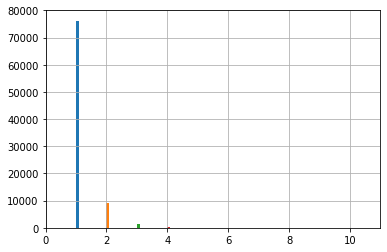

In [42]:
grouped.groupby("counts")["counts"].hist()

Most of the customers do not have enough data to use item-based filtering approach

In [ ]:
item_item_sim_matrix = pd.DataFrame(
    cosine_similarity(customer_item_matrix.T)
)

In [ ]:
item_item_sim_matrix

If you compare this code with the previous one, in which we calculate an array of similarities between users, the only difference is that here we are transposing the customer_item_matrix, so that the indexes in the rows represent individual items and the columns represent the customers.

In [ ]:
item_item_sim_matrix.columns = customer_item_matrix.T.index

item_item_sim_matrix['article_id'] = customer_item_matrix.T.index
item_item_sim_matrix = item_item_sim_matrix.set_index('article_id')

In [ ]:
item_item_sim_matrix

Let's suppose that a new customer has just bought a product with article_id 108775015, and we want to include in our marketing emails some products that this customer is most likely to buy. The first thing we have to do is to find the items most similar to the one with article_id 108775015. You can use the following code to get the 10 items most similar to the item with article_id 108775015:

In [ ]:
top_10_similar_items = list(
   item_item_sim_matrix\
        .loc['108775015']\
        .sort_values(ascending=False)\
        .iloc[:10]\
    .index
)

In [ ]:
top_10_similar_items

In [ ]:
articles.loc[
    articles['article_id'].isin(top_10_similar_items), 
    ['article_id', 'prod_name', 'product_type_name', 'graphical_appearance_name', 'colour_group_name']
].drop_duplicates().set_index('article_id')

#### 2.5.3 Content-Based Filtering

https://www.kaggle.com/code/fabiendaniel/film-recommendation-engine/notebook

SIMILARITY

Criteria to determine if two products are similar:
1. Section and Type (both together)
2. Graphical appearence
3. Colour

## 2. Popularity Function

In [ ]:
def popularity(unordered_items) #list of items within a cluster
    return ordered_items  #return list of items ordered by most purchased